# Workflow part 2:
---
### In this part we will do four substeps:

- Calculate Spearman correlation between rasters

- Transform each raster to shapefile (polygonize method)

- Normalize (Z-score)
    
- Merge shapefiles into one

In [1]:
import os
import re
import scipy
import rasterio
import functools
import itertools
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
from module_func_rast import *
# from module_func_rast import Raster_operations

In [2]:
def rasters_correlation(file1, file2, boostrap=False):

    # Reading rasters
    with rasterio.open(file1) as tif:
        rast1 = tif.read(1)

    with rasterio.open(file2) as tif2:
        rast2 = tif2.read(1)

    # Check raster's rows and columns are the same
    if rast1.shape == rast2.shape:
        print('Rasters have the same extent!', '\n' )
    else:
        print('Rasters rows and columns are different')
        exit()

    # Transforming rasters in 1D array
    rast1 = rast1.flatten()
    rast2 = rast2.flatten()

    # Avoiding nan values to compute correlation only when existe information on both
    x_rast1 = rast1[np.logical_not(np.isnan(rast1) | np.isnan(rast2))]
    y_rast2 = rast2[np.logical_not(np.isnan(rast1) | np.isnan(rast2))]

    # Check if they have the same lenght data
    print('Cells rast1 before', len(rast1), 'after', len(x_rast1))
    print('Cells rast2 before', len(rast2), 'after', len(y_rast2), '\n')

    # Basic Stats
    rast1_mean = np.nanmean(x_rast1)
    rast1_std = np.nanstd(x_rast1)
    rast2_mean = np.nanmean(y_rast2)
    rast2_std = np.nanstd(y_rast2)

    # Computing Pearson and Spearman Correlation (without bootstrapping)
    cor_pearson = scipy.stats.pearsonr(x_rast1, y_rast2)
    cor_spearman = scipy.stats.spearmanr(x_rast1, y_rast2)
    cor_kendall = scipy.stats.kendalltau(x_rast1, y_rast2)

    # Compunting Levene test (homocedasticity)
    levene = scipy.stats.levene(x_rast1, y_rast2)

    # Computing Normality (Anderson-Darling)
    anderson1 = scipy.stats.anderson(x_rast1)
    anderson2 = scipy.stats.anderson(y_rast2)
    kolm_stats = scipy.stats.kstest(x_rast1, 'norm')

    results = {'File1':os.path.basename(file1), 'File2': os.path.basename(file2),
    'Pearson stat': cor_pearson[0], 'Pearson pvalue': cor_pearson[1], 
    'Spearman stat': cor_spearman[0], 'Spearman p-value': cor_spearman[1], 
    'Kolmogorov stats': kolm_stats[0], 'Kolmogorov pvalue': kolm_stats[1],
    'Levene stat': levene[0], 'Levene pvalue': levene[1], 
    'Kendall stat': cor_kendall[0], 'Kendall pvalue': cor_kendall[1],
    'Anderson stats Raster 1': anderson1[0], 'Anderson stats Raster 1': anderson1[1][2],
    'Anderson stats Raster 1': anderson2[0], 'Anderson stats Raster 1': anderson2[1][2],
    'Mean Raster 1': rast1_mean, 'Std Raster 1': rast1_std,
    'Mean Raster 2': rast2_mean, 'Std Raster 2': rast2_mean}
    
        # Computing Spearman correlation with bootstrapping
    if boostrap == True:
        bootstrap_val, bootstrap_p, bsp = [], [], []
        # Index List
        indexes = np.arange(len(rast1))
        n_amostras = int(len(rast1)*0.7)
        s, p2 = [], []

        # Spearmann bootstrap
        for i in range(1000):
            new_order = np.random.choice(indexes, size = n_amostras, replace=True)
            x = rast1[new_order]
            y = rast2[new_order]

            stats, p = scipy.stats.spearmanr(x, y)
            bootstrap_val.append(stats)
            bootstrap_p.append(p)

        # Intervalo de 95% de confianca
        confidence_interval = np.percentile(bootstrap_val, [2.5, 97.5])
        bsp.append([np.mean(bootstrap_val), np.mean(bootstrap_p), confidence_interval])
        
        return results, bsp

    else: 
        return results


## Computing correlations between rasters

In [63]:
path1 = r'D:\Programming\UAV\dataset\orthomosaicCN_20181206_p038_R.tif'
path2 = r'D:\Programming\UAV\dataset\orthomosaicCN_20181206_p038_G.tif'

# Spearman correlation Without bootstrapping
results = rasters_correlation(path1, path2, boostrap=False)

# Spearman correlation With bootstrap
stats_result, bootstap_result = rasters_correlation(path1, path2, boostrap=True)

# Saving dataframe
df_correlations = pd.DataFrame([stats_result])
#df_correlations.to_csv('D:/test_correlation_rasters.csv', sep=';', header=True,  decimal = ',')

# Checking output
df_correlations.head()

Rasters have the same extent! 

Cells rast1 before 7373 after 4731
Cells rast2 before 7373 after 4731 

Rasters have the same extent! 

Cells rast1 before 7373 after 4731
Cells rast2 before 7373 after 4731 



,File1,File2,Pearson stat,Pearson pvalue,Spearman stat,Spearman p-value,Kolmogorov stats,Kolmogorov pvalue,Levene stat,Levene pvalue,Kendall stat,Kendall pvalue,Anderson stats Raster 1,Mean Raster 1,Std Raster 1,Mean Raster 2,Std Raster 2
0,orthomosaicCN_20181206_p038_R.tif,orthomosaicCN_20181206_p038_G.tif,0.999836,0.0,0.99986,0.0,0.502811,0.0,323.707804,3.439310e-71,0.990704,0.0,0.786,0.054058,0.012505,0.039694,0.039694


## Polygonize (raster to shapefile)

Number of shapefiles: 3


Text(0.5, 1, 'Raster to shapefile!')

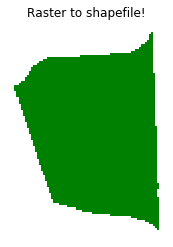

In [64]:
rasters = [r'D:\Programming\UAV\dataset\orthomosaicCN_20181206_p038_B.tif', 
            r'D:\Programming\UAV\dataset\orthomosaicCN_20181206_p038_R.tif',
            r'D:\Programming\UAV\dataset\orthomosaicCN_20181206_p038_G.tif']
shapefiles = []
for raster in rasters:
    polygonize = Raster_operations(raster, writing=False).polygonize()
    shapefiles.append(polygonize)

# Checking results
print(f"Number of shapefiles: {len(shapefiles)}")

# Plotting one
shapefiles[0].plot(color='green')
plt.axis('off')
plt.title('Raster to shapefile!')

In [5]:
len(shapefiles[0])

4731

## Z-score Normalization
Using all the shapefiles created earlier we will plot normalize them adding a new column to GeoDataframe

In [66]:
shp_zscore = []
for shp, number in zip(shapefiles, range(len(shapefiles))):
    shp[f'vals_zscore_{number}'] = (shp['raster_val'] - shp['raster_val'].mean() ) / shp['raster_val'].std(ddof=1)
    shp_zscore.append(shp)

# Checking results
print(f"Number of shapefiles: {len(shp_zscore)}")
shp_zscore[0].head()

Number of shapefiles: 3


,geometry,raster_val,vals_zscore_0
0,"POLYGON ((251640.000 7222600.000, 251640.000 7...",-0.006224,1.564088
1,"POLYGON ((251630.000 7222590.000, 251630.000 7...",-0.006501,1.529497
2,"POLYGON ((251640.000 7222590.000, 251640.000 7...",-0.004860,1.734322
3,"POLYGON ((251630.000 7222580.000, 251630.000 7...",-0.010469,1.034323
4,"POLYGON ((251640.000 7222580.000, 251640.000 7...",-0.018871,-0.014259


In [67]:
# Let's check if shapefiles has the same centroid location
# To simplify, We will only check the 2 firsts

shp1 = shp_zscore[0]['geometry'].centroid.map(lambda p: (p.x, p.y))
shp2  = shp_zscore[1]['geometry'].centroid.map(lambda p: (p.x, p.y))

(shp1 == shp2).all()

True

Since all shapefiles share same geometry we can merge them.

 If your shapefiles DON'T have the same centroid location don't perform a merge. 

In [68]:
# Since all shapefiles share same geometry we can merge them
# If your shapefiles DO NOT 
df_merged = functools.reduce(lambda  left,right: pd.merge(left,right,on=['geometry'],
                                            how='outer'), shp_zscore)
df_merged.head()

,geometry,raster_val_x,vals_zscore_0,raster_val_y,vals_zscore_1,raster_val,vals_zscore_2
0,"POLYGON ((251640.000 7222600.000, 251640.000 7...",-0.006224,1.564088,0.050466,-0.287209,0.037280,-0.267334
1,"POLYGON ((251630.000 7222590.000, 251630.000 7...",-0.006501,1.529497,0.043645,-0.832619,0.032248,-0.824462
2,"POLYGON ((251640.000 7222590.000, 251640.000 7...",-0.004860,1.734322,0.053358,-0.055958,0.039399,-0.032675
3,"POLYGON ((251630.000 7222580.000, 251630.000 7...",-0.010469,1.034323,0.036810,-1.379179,0.027270,-1.375526
4,"POLYGON ((251640.000 7222580.000, 251640.000 7...",-0.018871,-0.014259,0.030239,-1.904573,0.022448,-1.909353
...,...,...,...,...,...,...,...
4726,"POLYGON ((251660.000 7221660.000, 251660.000 7...",-0.012349,0.799651,0.025270,-2.301930,0.018620,-2.333251
4727,"POLYGON ((251670.000 7221660.000, 251670.000 7...",-0.015848,0.362984,0.027555,-2.119220,0.020236,-2.154248
4728,"POLYGON ((251660.000 7221650.000, 251660.000 7...",-0.019829,-0.133760,0.034454,-1.567541,0.025323,-1.591118
4729,"POLYGON ((251670.000 7221650.000, 251670.000 7...",-0.019806,-0.130961,0.016638,-2.992092,0.012288,-3.034293


## Saving spatial join!
Be awere that depending on the geographical extent of the original rasters and their spatial resolution the output will be very large.
Here, I will save our spatial join in *ESRI shapefile* format/driver, but you can save into a geojson or other format.

In [72]:
# 1st check the EPSG and save it
print(df_merged.crs)
df_merged.to_file(r'D:/Programming/UAV/dataset/Spatial_Join.shp')

{'init': 'EPSG:31982'}
